In [2]:
import pandas as pd
import os

In [3]:
pwd = os.getcwd()
filepath = os.path.join(pwd, "wine.csv")

In [4]:
data_import = pd.read_csv(filepath)
data_import

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


<Axes: >

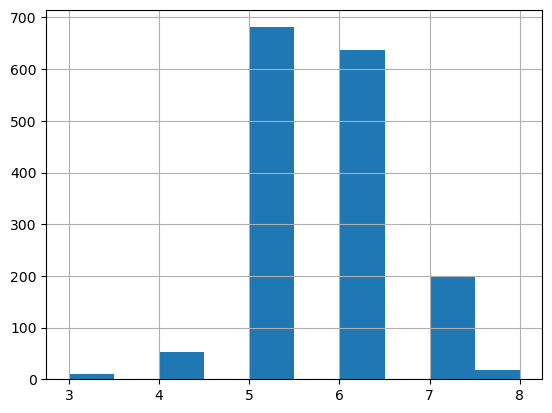

In [5]:
#quality is a column in this dataset. This is what we are looking to predict

data_import["quality"].hist()

In [6]:
# based on the above histogram, we are going to classify wine as good if quality is greater than 5 and bad if less than 5

y= data_import["quality"] > 5
y

0       False
1       False
2       False
3        True
4       False
        ...  
1594    False
1595     True
1596     True
1597    False
1598     True
Name: quality, Length: 1599, dtype: bool

In [7]:
X = data_import.drop("quality", axis = 1)
X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9
...,...,...,...,...,...,...,...,...,...,...,...
1130,9.1,0.600,0.00,1.9,0.058,5.0,10.0,0.99770,3.18,0.63,10.4
1294,8.2,0.635,0.10,2.1,0.073,25.0,60.0,0.99638,3.29,0.75,10.9
860,7.2,0.620,0.06,2.7,0.077,15.0,85.0,0.99746,3.51,0.54,9.5
1459,7.9,0.200,0.35,1.7,0.054,7.0,15.0,0.99458,3.32,0.80,11.9


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[ 0.21833164,  0.88971201,  0.19209222, ...,  1.09349989,
         0.45822284,  1.12317723],
       [-1.29016623, -1.78878251,  0.65275338, ..., -0.40043872,
        -0.40119696,  1.40827174],
       [ 1.49475291, -0.78434707,  1.01104539, ..., -0.07566946,
         0.51551749, -0.58738978],
       ...,
       [-0.65195559,  0.49909822, -1.08752211, ...,  1.28836145,
        -0.68767023, -0.87248428],
       [-0.24582155, -1.84458448,  0.39683051, ...,  0.05423824,
         0.80199076,  1.40827174],
       [-1.46422367, -1.34236676, -0.06383064, ...,  0.50891521,
        -0.68767023,  2.92877575]])

In [10]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled


array([[-3.61859850e-01,  1.64286407e-01, -9.85152962e-01, ...,
        -4.65392578e-01, -1.34389336e-04, -7.77452782e-01],
       [-3.03840702e-01, -1.70525408e-01, -5.24491803e-01, ...,
         5.08915214e-01, -1.03143815e+00, -8.72484283e-01],
       [ 1.37871461e+00,  7.78108067e-01, -2.68568937e-01, ...,
        -2.05577167e-01,  1.83329452e+00, -4.92358280e-01],
       ...,
       [-1.37449586e-02,  3.87494284e-01, -1.15015218e-01, ...,
        -1.04997725e+00, -7.44964886e-01, -5.87389780e-01],
       [ 2.76350785e-01, -1.45397070e+00,  6.01568807e-01, ...,
        -1.04997725e+00,  1.71749571e-01,  7.43051230e-01],
       [ 4.50408230e-01,  1.30822677e+00, -1.18989125e+00, ...,
        -1.40623314e-01, -6.87670232e-01, -6.82421281e-01]])

In [11]:
def preprocessing_function(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test


In [13]:
from sklearn.svm import SVC #support vector classifier


svc_clf = SVC()
svc_clf.fit(X_train_scaled, y_train)


SVC()

In [14]:
svc_clf_predictions = svc_clf.predict(X_test_scaled)
svc_clf_predictions

array([False, False,  True, False,  True, False, False, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True, False, False, False,  True,  True, False,  True,  True,
       False, False,  True, False, False,  True, False,  True, False,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
       False, False,  True, False,  True, False,  True,  True, False,
       False,  True, False,  True, False,  True, False,  True, False,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False,  True,  True, False,  True,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True, False, False,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True, False,  True,  True,  True,
       False, False,  True,  True,  True,  True, False, False, False,
        True,  True,

In [23]:

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def algo_accuracy(y_test, predictions):
    cm = confusion_matrix(y_test, svc_clf_predictions, labels= svc_clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_clf.classes_)
    disp.plot()
    plt.show()

    accuracy=accuracy_score(y_test, svc_clf_predictions)
    precision = precision_score(y_test, svc_clf_predictions)
    recall = recall_score(y_test, svc_clf_predictions)
    return accuracy, precision, recall


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    #try 12 (3x4) combinations of hyperparameters
    {
        'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    #then try 6 (2x3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},

]

rfc = RandomForestClassifier()

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy')

In [20]:
rfc_clf = grid_search.best_estimator_
rfc_clf

RandomForestClassifier(max_features=4, n_estimators=30)

In [21]:
rfc_predictions = rfc_clf.predict(X_test)
rfc_predictions

array([False, False, False, False,  True, False, False, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
        True, False, False,  True, False,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True,  True, False,
        True,  True, False,  True, False, False,  True, False,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True, False,  True, False,  True,  True, False,
        True, False, False,  True,  True, False,  True,  True, False,
        True, False, False, False, False,  True, False,  True, False,
        True, False, False,  True,  True,  True,  True,  True, False,
        True, False,  True, False,  True, False, False,  True, False,
       False, False,  True,  True,  True,  True, False,  True, False,
        True, False,

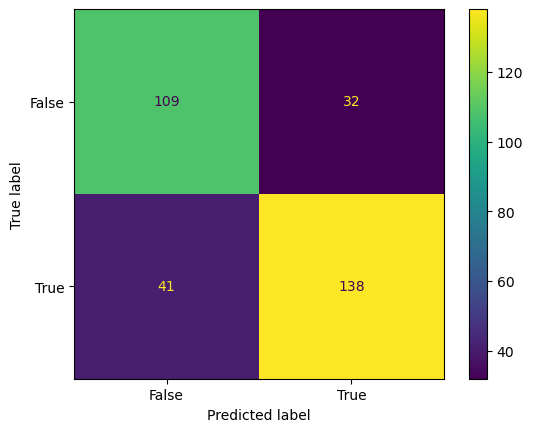

(0.771875, 0.8117647058823529, 0.770949720670391)

In [24]:
algo_accuracy(y_test, rfc_predictions)

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6]}]


knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10_000], y_train[:10_000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [38]:
knn_clf = grid_search.best_estimator_

print(knn_clf)

KNeighborsClassifier(n_neighbors=4, weights='distance')


In [39]:
grid_search.best_score_

0.9441999999999998

In [40]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

In [45]:
sample = mnist.target[:10]
sample

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4'], dtype=object)

In [60]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [61]:
train_data, test_data = load_titanic()

AttributeError: 'PosixPath' object has no attribute 'is_folder'